# Linear elasticity

## Review of the formulation

Linear elastic bodies are caracterized by a quadratic strain energy density function 

$$w(\varepsilon)=\frac{1}{2} \mathbb{C} \,(\varepsilon-\varepsilon_0)\cdot (\varepsilon-\varepsilon_0)$$
where

-  $\varepsilon$ is the second order (symmetric) strain tensor
- $\varepsilon_0$ is the inelastic strain (e.g. for thermal strain in isotropic materials $\varepsilon_0=-\alpha \Delta T$
- $\mathbb{C}$ is the forth order elastic tensor.

The (symmetric) stress tensor is defined as 
$$
\sigma(\varepsilon) = \dfrac{\partial w(\varepsilon)}{\partial \varepsilon}
$$
For isotropic materials denoting by $\lambda$ and $\mu$ are the Lamé moduli.

$$
w(\varepsilon) = \frac{\lambda}{2} (\mathrm{tr}(\varepsilon-\varepsilon_0))^2+\mu \Vert\varepsilon-\varepsilon_0\Vert^2, 
\qquad 
\sigma(\varepsilon)={\lambda}\,\mathrm{tr}(\varepsilon-\varepsilon_0)+2\mu (\varepsilon-\varepsilon_0)
$$

The strain is given in therm of the displacement by $$ \varepsilon(u)=\mathrm{sym}(\nabla u)=\dfrac{\nabla u+\nabla u^T}{2}$$
Note that here $u,v$ are vector fields in $\mathcal R^2$ or $\mathcal R^3$.

Considering a body $\Omega$ submitted to body forces $b$ surface, traction $f$ on $\partial_f \Omega$, applied displacements $\bar u$ on $\partial_u\Omega$, and inelastic strain $\varepsilon_0$, the  weak formulation is: 

Find a *trial function* $u\in V$, $u=\bar u$ on $\partial_u\Omega$, such that for each *test function* in $v\in V$, $v=0$ on $\partial_u\Omega$: 

$$
a(u,v) = l(v)
$$
where 
$$a(u,v)=\int_\Omega \sigma(\varepsilon(u))\cdot \varepsilon(v)\,\mathrm{d}x, \quad \ell(v)=\int_\Omega b\cdot v\, \mathrm{d}x+\int_{\partial_f \Omega} f\cdot v$$

**Exercices:**

1. Show that the weak formulation above coincides with the stationarity condition of the following minimization problem for the potential energy $\mathcal E(u)$
$$
\min_{u\in V, \, u=\bar u \text{ on } \partial_u\Omega}\mathcal E(u),\qquad \mathcal E(u)=\dfrac{1}{2}a(u,u) - l(u)
$$
2. Show that the weak formulation above is equivalent to the classical equation of linear elasticity in the strong form with the associated Dirichlet et Neumann boundary conditions
3. Show by dimensional analysis that, without loss of generality, one can set, up to a rescaling of the variables, $L:=\vert\Omega\vert=1$ and $\lambda=1$ when performing numerical computations

## Finite element solution (with FEniCS)

We will solve now the classical problem of the traction of plate with a hole (in plane-strain)

From now on I will import fenics in the main namespace

In [1]:
import dolfin as df
import mshr
import numpy as np
import matplotlib.pyplot as plt
import ufl
%matplotlib inline

### Mesh 

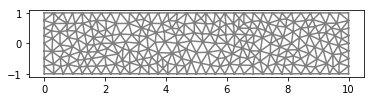

In [2]:
xmin, xmax = 0, 10.
ymin, ymax = -1., 1.
n = 20
p1 = df.Point(xmin, ymin)
p2 = df.Point(xmax, ymax)
square = mshr.Rectangle(p1,p2)
mesh = mshr.generate_mesh(square,n)
df.plot(mesh)

### Function space

In [3]:
element = df.VectorElement("P", df.triangle, degree = 1)
# Create function space
V = df.FunctionSpace(mesh, element)
# Create test and trial functions, and source term
u = df.TrialFunction(V)
v = df.TestFunction(V)

### BCs 

In [4]:
bc_left = df.DirichletBC(V, (0.,0.), "near(x[0],%s,1.e-5)"%xmin)
bcs = [bc_left]

###  Variational formulation

Define the constitutive parameters, strain and stress tensors

In [5]:
# Bulk load 
body_force = df.Constant((1.,0.))
# Elasticity parameters
E, nu = df.Constant(100), df.Constant(0.3)
mu, lmbda = E/(2*(1.0 + nu)), E*nu/((1.0 + nu)*(1.0 -2.0*nu))

def eps(u):
    """strain tensor"""
    return ufl.sym(ufl.grad(u))

def sigma(epsilon):
    """stress tensor"""
    return  2*mu*epsilon + lmbda*ufl.tr(epsilon)* ufl.Identity(2)

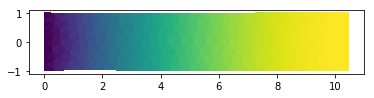

In [6]:
# Weak formulation
dx = df.dx
a = df.inner(sigma(eps(u)), eps(v))*dx 
L = df.inner(body_force,v)*dx

# Set up PDE and solve
us = df.Function(V,name="displacement")

A, b = df.assemble_system(a,L,bcs)
df.solve(A,us.vector(),b,"cg", "ilu")
# or 
# df.solve(a==L,us,bcs,solver_parameters={"linear_solver": "cg","preconditioner": "ilu"})
df.plot(us, mode = "displacement")

### Postprocessing: stress calculation

Define Von Mises Stress

In [7]:
sigma_sol = sigma(eps(us))
ndim = 2
s = sigma_sol - (1./ndim)*ufl.tr(sigma_sol)*ufl.Identity(ndim)

Project it on a FE function space

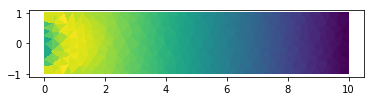

In [8]:
stress_element = df.FiniteElement('DG', df.triangle, 0)
S = df.FunctionSpace(mesh, stress_element)
von_Mises = ufl.sqrt(ndim*ufl.inner(s, s))
von_Mises_p = df.project(von_Mises, S)
df.plot(von_Mises_p)

Text(0.5,0,'Von Mises stress')

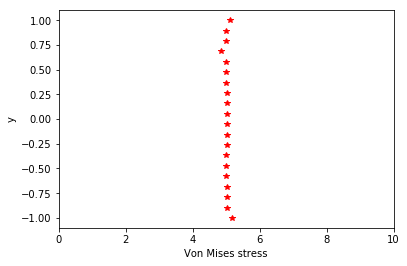

In [10]:
ypoints = np.linspace(ymin, ymax, 20)
points = [[xmax/2.,y] for y in ypoints]
values = [von_Mises_p(point) for point in points]
plt.plot(values, ypoints, '*r')
plt.xlim([0,10])
plt.ylabel("y")
plt.xlabel("Von Mises stress")

# Write the result to a file

You can file the file to disk and read in paraview

In [34]:
with df.XDMFFile(mesh.mpi_comm(), "output/u.xdmf") as file:
    file.write(us,  0)

# Exercice

1. Solve the problem for the case of body force (0.,1.), i.e. a horizontal beam under the effect of the gravity

2. Create a function `elastic_solver`, that you can call as follows to solve the problem above:

`elastic_solver(20, "cg", "ilu", df.Constant((1.,0.)))`


In [ ]:
def elastic_solver(n_element, length, height, linear_solver, preconditioner, body_force):
    """
    Return the displacement fielf u_sol given the n_elements (integer),
    the linear_solver (string), the beam length (float) and height (float) the preconditioner (string), and the body force vector (dolfin constant))
    
    """
    return u_sol

3. Plot the maximum deflection as a function of the mesh size  

4. Compare the results for the maximum deflection as a function of the aspect ratio with the beam theory.

